In [3]:
#Libs ----
import pandas as pd
import numpy as np
np.random.seed(42)
import re
import sys
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score, precision_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
#--
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import r2_score, f1_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve
from sklearn.model_selection import KFold
from ml_metrics import rmsle
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

##--
#def ----
def get_col_names(df, black_list=['Target']):
    col = train.select_dtypes(include=[np.number, np.bool]).columns.values
    return [x for x in col if x not in black_list]

def train_and_predict(model, X, y, test_size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2018)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 

    return accuracy_score(y_test, y_pred)

def total(X, y , model):

    cv = StratifiedKFold(n_splits=3, random_state=2018, shuffle=True)
   
    scores = []
    for df_idx, test_idx in cv.split(X, y):
        model.fit(X[df_idx], y[df_idx])
        y_pred = model.predict(X[test_idx])

        score = accuracy_score(y[test_idx], y_pred )
        scores.append(score)

    return (np.max(scores), np.mean(scores), np.std(scores))
    

def compare(model_name, model, X, y):

    print(model_name)
    print(train_and_predict(model, X, y, test_size=0.33))
    print(total(X, y, model))
    
    print()

##--
#clean ----
def check_missing():
    for column in train.columns:
        missing = column, train[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)


In [4]:
##--
#data ----
train = pd.read_hdf('../input/train_online_retail.h5')

test = pd.read_hdf('../input/test_online_retail.h5')

orders_train =  pd.read_csv('../input/orders_train.csv') 
check_missing()

train = train.fillna('-1')
test = test.fillna('-1')

cat_feats = train.select_dtypes(include=[np.object]).columns
cat_feats_test = test.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    train['{0}_cat'.format(cat_feat)] = pd.factorize( train[cat_feat] )[0]
    
for cat_feat_test in cat_feats_test:
    test['{0}_cat'.format(cat_feat_test)] = pd.factorize( test[cat_feat_test] )[0]
    
feats = get_col_names(train, black_list = ['is_canceled', 'is_test'])
feats

('description', 2239)


['invoice',
 'stock_code',
 'quantity',
 'price_unit',
 'price_total',
 'customer_id',
 'description_cat',
 'country_cat']

In [5]:
## feature engineering ---- bezużyteczna cecha

def vintage_15andmore (row):
    description = row['description']
    price_total = row['price_total']
    if price_total >= 15 and description == 'vintage':
        return 1
    else:
        return 0

train['vintage_15andmore'] = train[['description', 'price_total']].apply(vintage_15andmore, axis=1)
test['vintage_15andmore'] = test[['description', 'price_total']].apply(vintage_15andmore, axis=1)


In [6]:
#Model ----
X = train[feats].values
y = train['is_canceled'].values

model = RandomForestClassifier(max_depth = 5, n_estimators = 100, random_state = 0)

model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

RandomForest_MD5
0.9805886838884154
(0.980966882375333, 0.9809321299385458, 4.1116405688485156e-05)



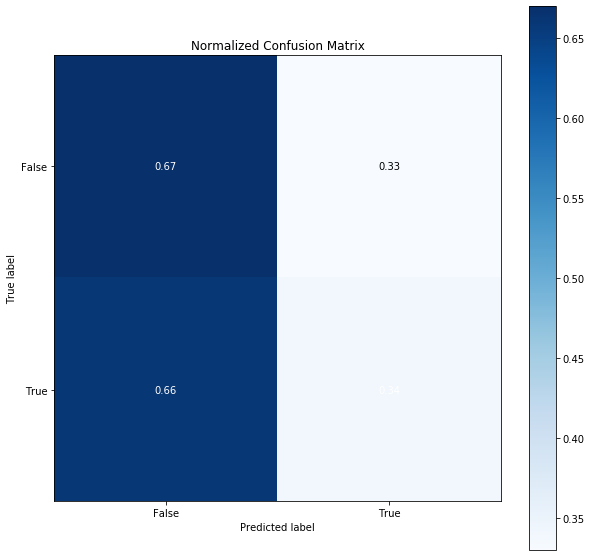

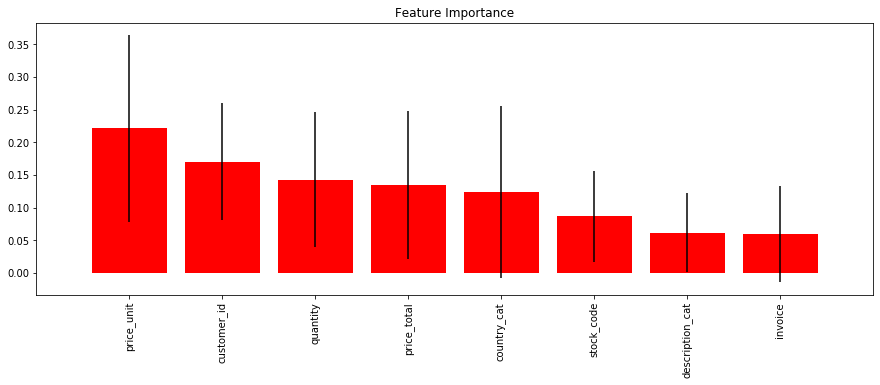

In [7]:
y_pred = cross_val_predict(model, X, y, cv=3)
skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(10 ,10));

skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5));

compare('RandomForest_MD5', RandomForestClassifier(max_depth = 5, n_estimators = 100, random_state = 0), X, y)

In [8]:
#SUBMIT

x_test = test[feats].values
y_test_pred = model.predict(x_test)

orders_test = test[feats]
#display(orders_test)

orders_test['is_canceled'] = y_test_pred

orders_test = orders_test.groupby('invoice', as_index = False)['is_canceled', 'price_total'].sum()

orders_test['is_canceled'] = orders_test['is_canceled'] > 0

orders_test['total_return'] = orders_test['price_total'] * orders_test['is_canceled'] 

orders_test[ ['invoice', 'total_return'] ].to_csv('../output/submit_RandomForestClassifier_k2.csv', index=False)